# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, sum
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
from datetime import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify_Churn_Analysis") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.createOrReplaceTempView("log_table")
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

Let's first drop duplicates.

In [4]:
df = df.dropDuplicates()

and log entries from unregistered users

In [5]:
df = spark.sql(" SELECT * FROM log_table WHERE userID != '' ")

In [6]:
df.createOrReplaceTempView("log_table")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Let's look at the columns:

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Now let's see in which timeframe the data was collected:

In [8]:
ts_begin = spark.sql('SELECT MIN(ts) FROM log_table').first()[0]
ts_end = spark.sql('SELECT MAX(ts) FROM log_table').first()[0]
begin_datettime = datetime.fromtimestamp(ts_begin/1000)
end_datetime = datetime.fromtimestamp(ts_end/1000)
print('Data was collected between {} and {} over {} days.'.format(str(begin_datettime), str(end_datetime), (ts_end - ts_begin)//(24*3600000)))

Data was collected between 2018-10-01 00:01:57 and 2018-12-03 01:11:16 over 63 days.


And let's look at the number of songs played per day over this period:

In [9]:
interval_step = (ts_end - ts_begin) / 63
intervals = np.arange(ts_begin, ts_end - interval_step, interval_step)
playcount = []
usercount = []
downgradecount = []
upgradecount = []
cancelcount = []
paidcount = []
freecount = []

for i in intervals:
    sql_request = 'SELECT count(ts) FROM log_table WHERE page = "NextSong" AND ts BETWEEN {} AND {}'.format(i, i + interval_step)
    playcount.append(spark.sql(sql_request).first()[0])
    sql_request = 'SELECT count(DISTINCT userID) FROM log_table WHERE page = "NextSong" AND ts BETWEEN {} AND {}'.format(i, i + interval_step)
    usercount.append(spark.sql(sql_request).first()[0])
    sql_request = 'SELECT count(DISTINCT userID) FROM log_table WHERE page = "Cancellation Confirmation" AND ts BETWEEN {} AND {}'.format(i, i + interval_step)
    cancelcount.append(spark.sql(sql_request).first()[0])
    sql_request = 'SELECT count(DISTINCT userID) FROM log_table WHERE page = "Submit Downgrade" AND ts BETWEEN {} AND {}'.format(i, i + interval_step)
    downgradecount.append(spark.sql(sql_request).first()[0])
    sql_request = 'SELECT count(DISTINCT userID) FROM log_table WHERE page = "Submit Upgrade" AND ts BETWEEN {} AND {}'.format(i, i + interval_step)
    upgradecount.append(spark.sql(sql_request).first()[0])
    sql_request = 'SELECT count(DISTINCT userID) FROM log_table WHERE level = "paid" AND ts BETWEEN {} AND {}'.format(i, i + interval_step)
    paidcount.append(spark.sql(sql_request).first()[0])
    sql_request = 'SELECT count(DISTINCT userID) FROM log_table WHERE level = "free" AND ts BETWEEN {} AND {}'.format(i, i + interval_step)
    freecount.append(spark.sql(sql_request).first()[0])

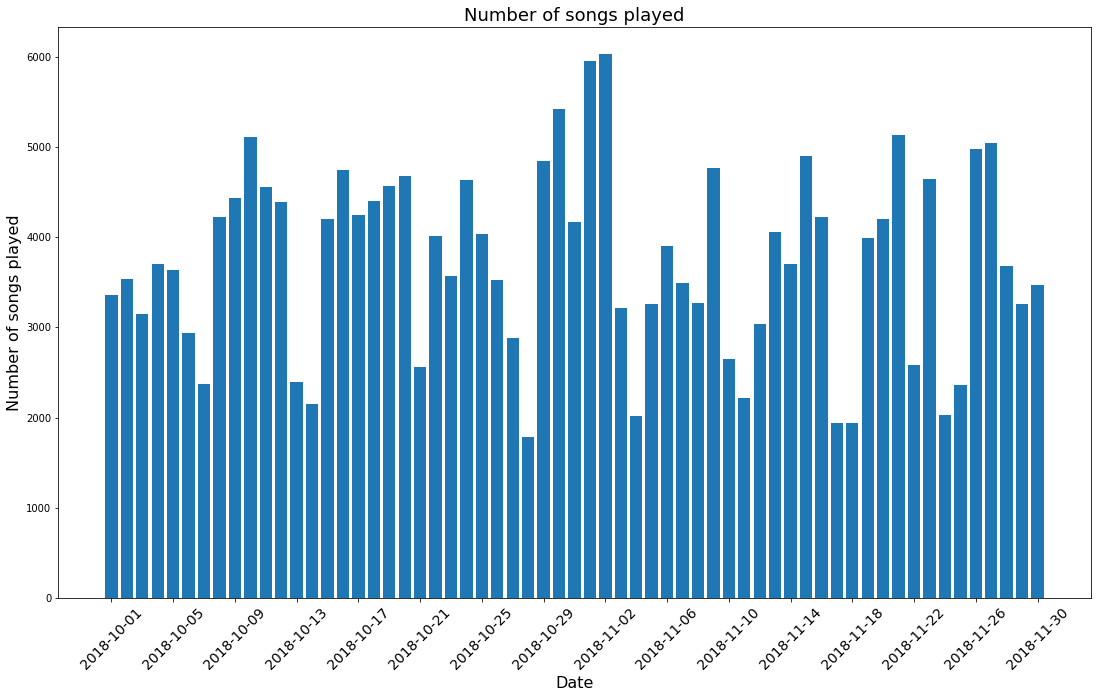

In [10]:
plt.bar(np.arange(0,61),playcount[:-1])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,62,4), [str(datetime.fromtimestamp(x/1000).date()) for x in intervals[::4]], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played', fontsize = 16)
plt.title('Number of songs played', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

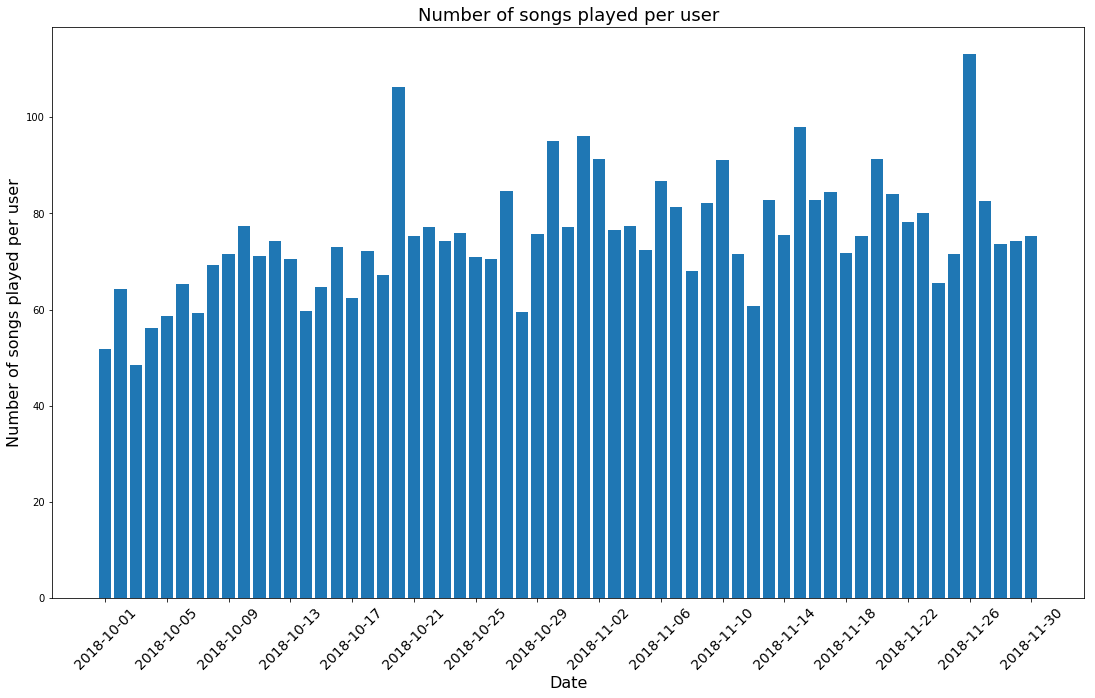

In [11]:
plt.bar(np.arange(0,61),[x/y for x,y in zip(playcount[:-1], usercount[:-1])])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,62,4), [str(datetime.fromtimestamp(x/1000).date()) for x in intervals[::4]], rotation=45, fontsize = 14)
plt.ylabel('Number of songs played per user', fontsize = 16)
plt.title('Number of songs played per user', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

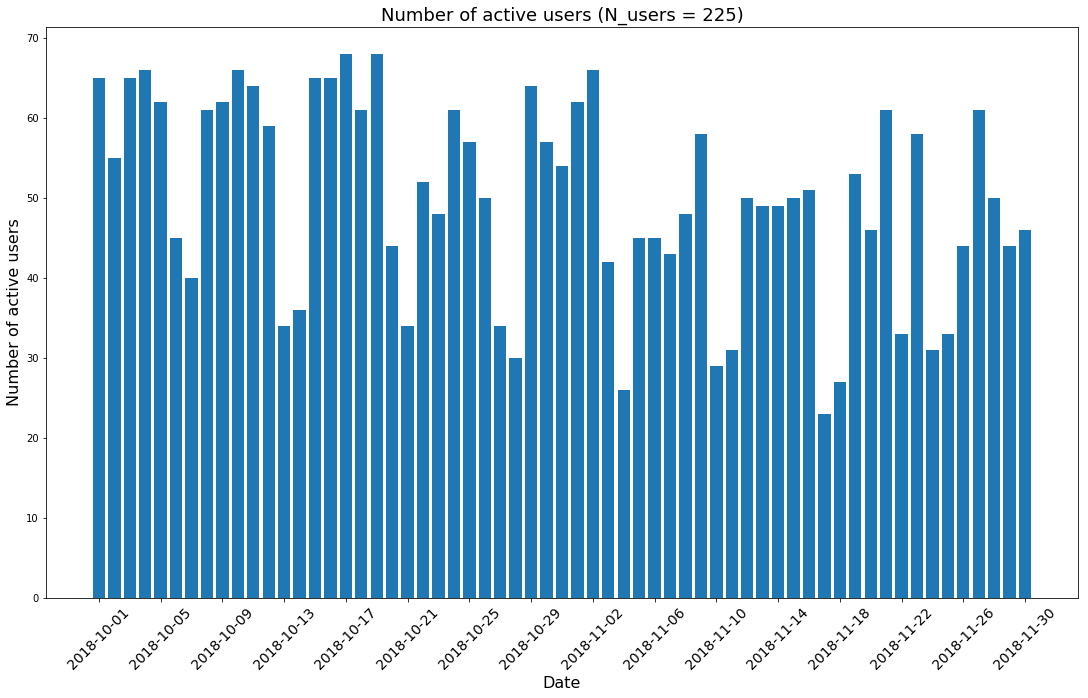

In [12]:
plt.bar(np.arange(0,61),usercount[:-1])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,62,4), [str(datetime.fromtimestamp(x/1000).date()) for x in intervals[::4]], rotation=45, fontsize = 14)
plt.ylabel('Number of active users', fontsize = 16)
plt.title('Number of active users (N_users = 225)', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

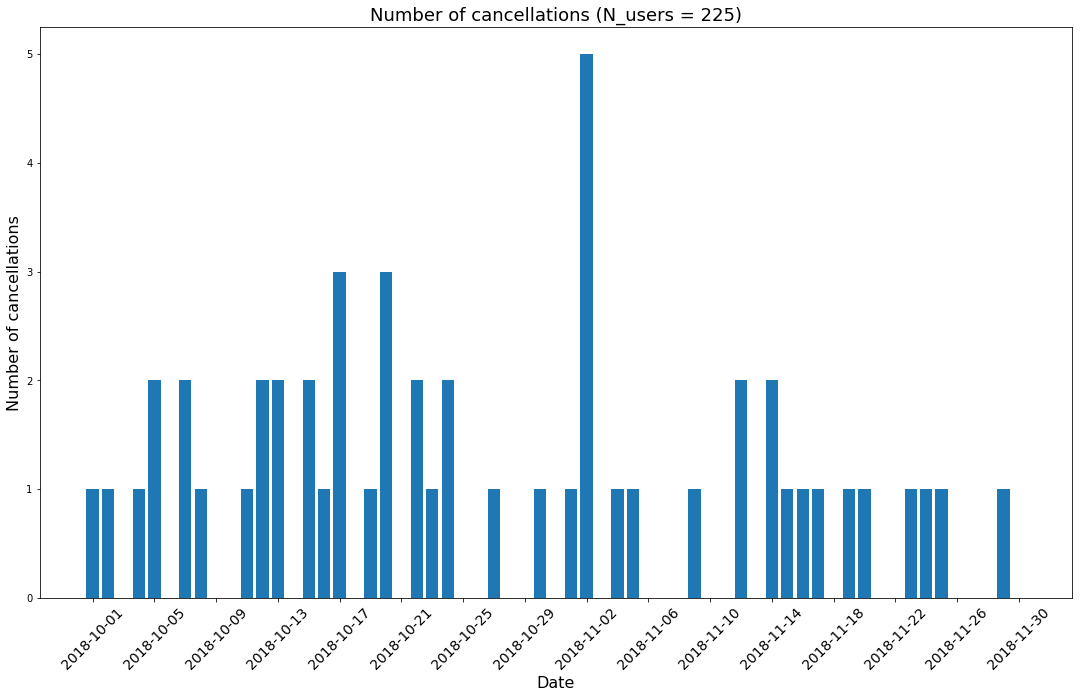

In [13]:
plt.bar(np.arange(0,61),cancelcount[:-1])
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,62,4), [str(datetime.fromtimestamp(x/1000).date()) for x in intervals[::4]], rotation=45, fontsize = 14)
plt.ylabel('Number of cancellations', fontsize = 16)
plt.title('Number of cancellations (N_users = 225)', fontsize = 18)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

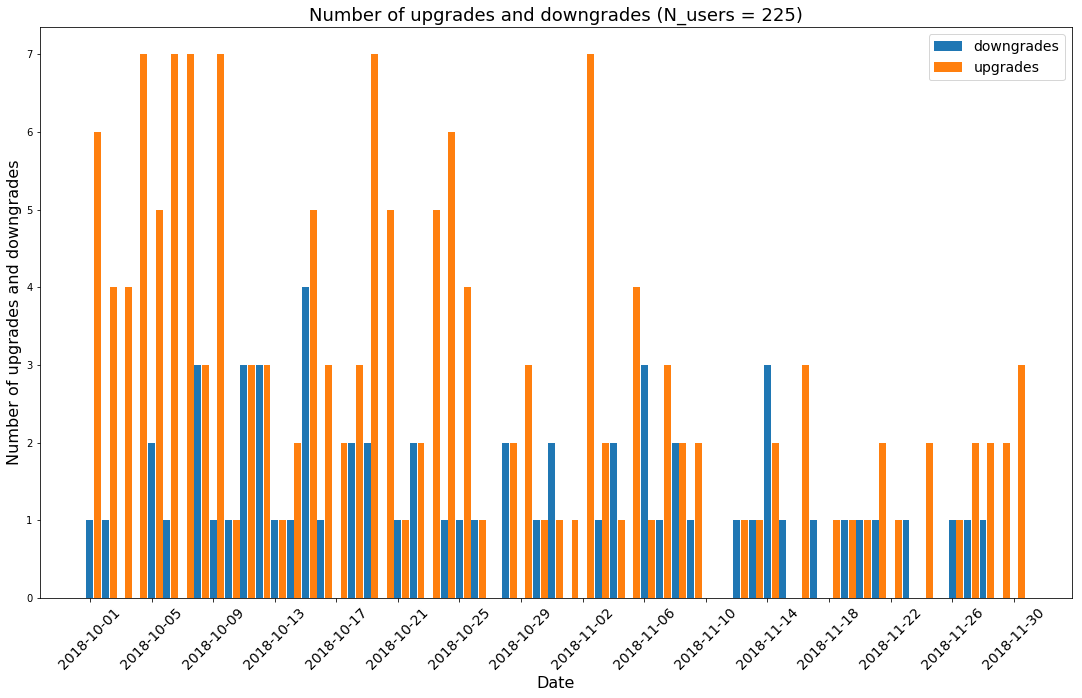

In [14]:
plt.bar(np.arange(0,61), downgradecount[:-1], width = 0.45, label = 'downgrades')
plt.bar(np.arange(0,61) + 0.5, upgradecount[:-1], width = 0.45, label = 'upgrades')
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,62,4), [str(datetime.fromtimestamp(x/1000).date()) for x in intervals[::4]], rotation=45, fontsize = 14)
plt.ylabel('Number of upgrades and downgrades', fontsize = 16)
plt.title('Number of upgrades and downgrades (N_users = 225)', fontsize = 18)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

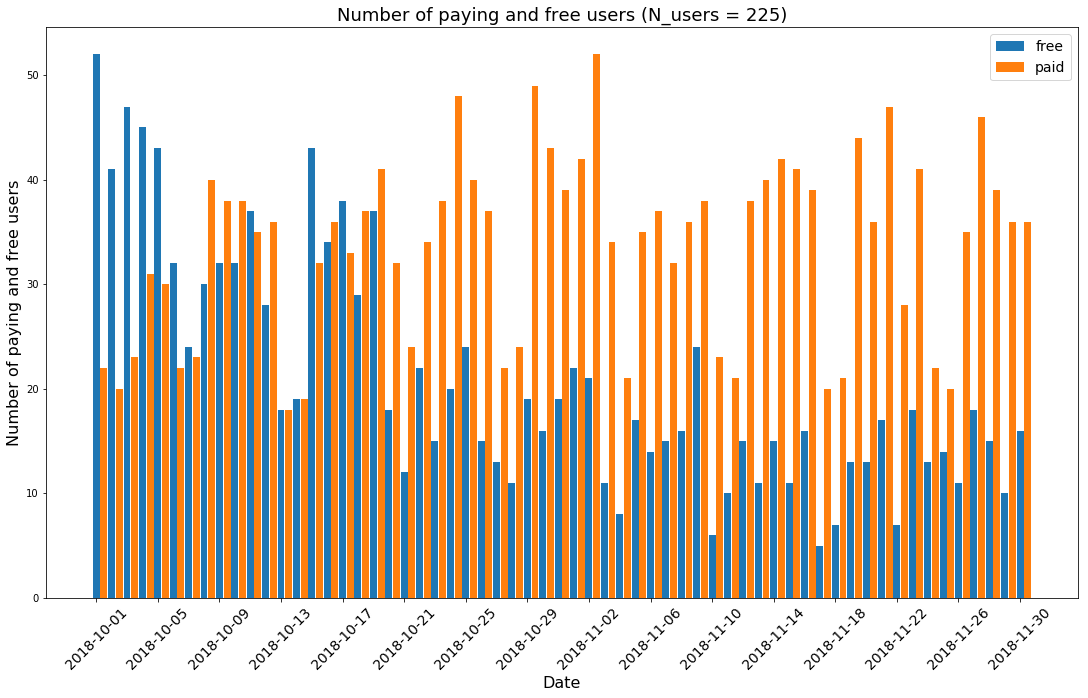

In [15]:
plt.bar(np.arange(0,61), freecount[:-1], width = 0.45, label = 'free')
plt.bar(np.arange(0,61) + 0.5, paidcount[:-1], width = 0.45, label = 'paid')
plt.xlabel('Date', fontsize = 16)
plt.xticks(np.arange(0,62,4), [str(datetime.fromtimestamp(x/1000).date()) for x in intervals[::4]], rotation=45, fontsize = 14)
plt.ylabel('Number of paying and free users', fontsize = 16)
plt.title('Number of paying and free users (N_users = 225)', fontsize = 18)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

This function will give an overview of distinct value counts and their distribution if the number of distinct values is smaller than 20.

In [16]:
def show_distinct_counts(column_name, table_name = 'log_table'):
    """Shows counts of distinct values of a column in an sql table.
    If the number of distinct values is smaller than 20 then
    counts for each value are displayed. Otherwise only the total
    number of distinct values is presented.
    
    INPUT:
        column_name (str): name of the column
        table_name (str): name of the table
        
    OUTPUT:
        none
    """
    n_distinct = spark.sql('SELECT COUNT(DISTINCT {}) AS count FROM {}'.format(column_name, table_name)).first()[0]
    #print(n_distinct)
    
    if n_distinct<=20:
        sql_query = 'SELECT {0}, count({0}) AS {0}_counts FROM {1} GROUP BY {0}'.format(column_name, table_name)
    else:
        sql_query = 'SELECT COUNT(DISTINCT {0}) AS Distinct_count_{0} FROM {1}'.format(column_name, table_name)
        
    spark.sql(sql_query).show()   

Let's apply this function to the dataframe's columns to get an overview of the data:

In [17]:
for column in df.columns:
    show_distinct_counts(column)

+---------------------+
|Distinct_count_artist|
+---------------------+
|                17655|
+---------------------+

+---------+-----------+
|     auth|auth_counts|
+---------+-----------+
|Cancelled|         52|
|Logged In|     278102|
+---------+-----------+

+------------------------+
|Distinct_count_firstName|
+------------------------+
|                     189|
+------------------------+

+------+-------------+
|gender|gender_counts|
+------+-------------+
|     F|       154578|
|     M|       123576|
+------+-------------+

+----------------------------+
|Distinct_count_itemInSession|
+----------------------------+
|                        1311|
+----------------------------+

+-----------------------+
|Distinct_count_lastName|
+-----------------------+
|                    173|
+-----------------------+

+---------------------+
|Distinct_count_length|
+---------------------+
|                14865|
+---------------------+

+-----+------------+
|level|level_counts|
+-----+--

This method didn't provide the results we wanted for gender and level. Let's do some extra evaluation for these columns.

First let's look at the gender distribution:

In [18]:
spark.sql(''' SELECT gender, count(DISTINCT userID) AS gender_counts FROM log_table GROUP BY gender ''').show()

+------+-------------+
|gender|gender_counts|
+------+-------------+
|     F|          104|
|     M|          121|
+------+-------------+



Let's see how many users changed their level:

In [19]:
spark.sql(''' SELECT levels AS level_counts, count(levels) AS users \
        FROM (SELECT count(DISTINCT level) AS levels \
        FROM log_table GROUP BY userID) GROUP BY levels ''').show()

+------------+-----+
|level_counts|users|
+------------+-----+
|           1|   90|
|           2|  135|
+------------+-----+



And how many users get their subscription cancelled:

In [20]:
spark.sql(''' SELECT auth, count(DISTINCT userID) AS auth_counts FROM log_table GROUP BY auth ''').show()

+---------+-----------+
|     auth|auth_counts|
+---------+-----------+
|Cancelled|         52|
|Logged In|        225|
+---------+-----------+



Let's define churn as following events:
1. Customer changed level from paid to free.
2. Customer cancelled their account.
The second case is easier to track. Since the number of cancelled auth and visits to "Cancellation Confirmation" page is same, we can assume, that after visiting the page and getting the cancelled auth the users have cancelled their accounts.

The first case is more complicated. We know that 135 users changed their level. There also have been 159 visits to "Submit Upgrade" page and 63 visits to "Submit Downgrade" page.

Let's see how many free and how many paying users cancel their accounts:

In [21]:
spark.sql('''SELECT level, count(DISTINCT userID) AS number_cancelled \
        FROM log_table WHERE page = "Cancellation Confirmation" GROUP BY level''').show()

+-----+----------------+
|level|number_cancelled|
+-----+----------------+
| free|              21|
| paid|              31|
+-----+----------------+



In [22]:
get_churn_cancel = udf(lambda x: int(x=='Cancellation Confirmation'), IntegerType())
df = df.withColumn('churn_cancelled', get_churn_cancel('page'))
df.createOrReplaceTempView("log_table")

##### Early churn
As we recall from our data analysis there are weekly patterns in user behaviour. If the user used the service for less than a week their data may be inconsistent with others, so later we can test if it makes sense to exclude early churn from our analysis.

In [23]:
# let's find early churn users:
early_churn = spark.sql(''' SELECT userID, ts FROM log_table WHERE churn_cancelled = 1 ''').toPandas()
early_churn.sort_values('ts', inplace = True)
early_churn[early_churn['ts'] < ts_begin + 3600*24*7*1000]
early_churn = early_churn[early_churn['ts'] < ts_begin + 3600*24*7*1000]

In [24]:
early_churn.userID.tolist()

['100011', '100001', '100024', '300007', '100006', '18', '100019']

# Feature Engineering

##### Methodology
It may seem to plausible to involve such factors as browser, platform, location or gender in the prediction of churn. These factors may lead to churn, but they are affecting certain groups of customers and are not related to individual customer experience. Therefore they will not help us to predict churn, but rather indicate which customer groups may be more dissatisfied with our service.

In this analysis we will focus on user specific factors such as:
 * number of songs played
 * number of different songs played
 * number of different artists
 * number of sessions
 * number of upgrades
 * number of downgrades
 * page visits
     * downgrade
     * upgrade
     * thumbs down
     * thumbs up
     * roll advert
     * home
     * logout
     * settings
     * save settings
     * add to playlist
     * help
     * error
     * about
     * add friend

In [25]:
df_churn = spark.sql('''
SELECT userID, count(song) AS song_count, \
count(DISTINCT song) AS dist_song_count, \
count(DISTINCT artist) AS dist_artist_count, \
count(DISTINCT sessionId) AS session_count, \
count(CASE WHEN page = "Submit Downgrade" THEN 1 END) AS downgrade_count, \
count(CASE WHEN page = "Submit Upgrade" THEN 1 END) AS upgrade_count, \
count(CASE WHEN page = "Cancellation Confirmation" THEN 1 END) AS churn, \
count(CASE WHEN page = "Home" THEN 1 END) AS page_visits_home, \
count(CASE WHEN page = "Logout" THEN 1 END) AS page_visits_logout, \
count(CASE WHEN page = "Settings" THEN 1 END) AS page_visits_settings, \
count(CASE WHEN page = "Save Settings" THEN 1 END) AS page_visits_save_settings, \
count(CASE WHEN page = "Thumbs Down" THEN 1 END) AS page_visits_thumbs_down, \
count(CASE WHEN page = "Thumbs Up" THEN 1 END) AS page_visits_thumbs_up, \
count(CASE WHEN page = "Upgrade" THEN 1 END) AS page_visits_upgrade, \
count(CASE WHEN page = "Downgrade" THEN 1 END) AS page_visits_downgrade, \
count(CASE WHEN page = "Roll Advert" THEN 1 END) AS page_visits_roll_advert, \
count(CASE WHEN page = "About" THEN 1 END) AS page_visits_about, \
count(CASE WHEN page = "Add to Playlist" THEN 1 END) AS page_visits_add_to_playlist, \
count(CASE WHEN page = "Add Friend" THEN 1 END) AS page_visits_add_friend, \
count(CASE WHEN page = "Help" THEN 1 END) AS page_visits_help, \
count(CASE WHEN page = "Error" THEN 1 END) AS page_visits_error \
FROM log_table GROUP BY userID ''').toPandas()

In [26]:
# let's look at the counts
df_churn.iloc[:10,:8]

,userID,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn
0,100010,275,269,252,7,0,0,0
1,200002,387,378,339,6,0,1,0
2,125,8,8,8,1,0,0,1
3,51,2111,1854,1385,10,0,0,1
4,124,4079,3339,2232,29,0,0,0
5,7,150,148,142,7,0,0,0
6,54,2841,2414,1744,37,1,1,1
7,15,1914,1707,1302,15,0,0,0
8,155,820,759,643,6,0,1,0
9,132,1928,1718,1299,16,0,1,0


In [27]:
# let's look at the page visits
df_churn.iloc[:10,7:]

,churn,page_visits_home,page_visits_logout,page_visits_settings,page_visits_save_settings,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
0,0,11,5,0,0,5,17,2,0,52,1,7,4,2,0
1,0,20,5,3,0,6,21,2,5,7,3,8,4,2,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,75,24,12,1,21,100,0,23,0,2,52,28,12,1
4,0,176,59,20,6,41,171,0,41,4,7,118,74,23,6
5,0,10,3,3,1,1,7,2,0,16,0,5,1,1,1
6,1,129,36,17,3,29,163,1,39,47,5,72,33,17,1
7,0,93,27,16,2,14,81,0,28,1,2,59,31,8,2
8,0,30,14,5,0,3,58,2,12,8,2,24,11,9,3
9,0,83,34,17,4,17,96,1,19,2,4,38,41,16,3


As discussed before we will remove users, who churned in less than one week.

In [28]:
df_churn = df_churn[~df_churn.userID.isin(early_churn.userID.tolist())]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5dc420cb38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5dc47f4320>]], dtype=object)

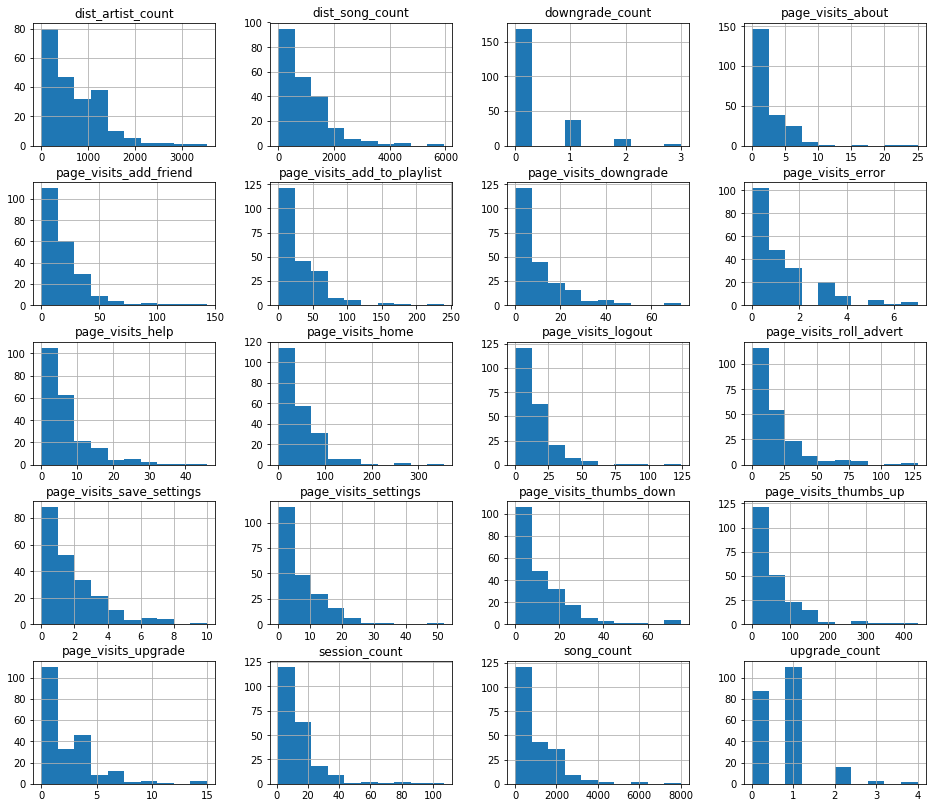

In [29]:
df_churn.drop(columns = ['churn']).hist(figsize = (16,14))

Let's rescale the statistics with the number of sessions.

In [89]:
df_div = df_churn.copy(deep = True)
df_div.iloc[:,1:4] = df_div.iloc[:,1:4].div(df_div.session_count, axis=0)
df_div.iloc[:,8:] = df_div.iloc[:,8:].div(df_div.session_count, axis=0)

In [90]:
df_div.describe()

,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn,page_visits_home,page_visits_logout,page_visits_settings,...,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,...,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,69.815479,64.206574,53.355827,14.495413,0.288991,0.729358,0.206422,3.146716,1.028254,0.484892,...,0.766735,3.745666,0.196105,0.577022,1.611608,0.154460,1.940166,1.366555,0.438610,0.084908
std,42.346979,37.811378,30.167894,14.720201,0.594884,0.734383,0.405668,1.575141,0.698332,0.423177,...,0.588750,2.278660,0.240154,0.578931,1.784380,0.201838,1.277408,0.909917,0.333966,0.130685
min,3.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.811304,36.495798,32.694079,6.000000,0.000000,0.000000,0.000000,2.067857,0.673077,0.235994,...,0.376488,2.119518,0.030357,0.000000,0.333333,0.000000,1.000000,0.750000,0.203526,0.000000
50%,64.750000,59.520833,48.522282,10.000000,0.000000,1.000000,0.000000,2.904545,1.000000,0.409007,...,0.666667,3.500000,0.142857,0.454545,1.026316,0.116516,1.804762,1.263889,0.388889,0.037088
75%,91.778571,84.488487,66.151989,18.000000,0.000000,1.000000,0.000000,3.902406,1.250000,0.661765,...,1.000000,5.000000,0.272727,0.898214,2.333333,0.216667,2.623162,1.800000,0.587518,0.124053
max,286.666667,246.444444,197.000000,107.000000,3.000000,4.000000,1.000000,11.000000,8.000000,4.000000,...,3.466667,13.777778,2.000000,2.444444,14.000000,2.000000,8.000000,4.666667,2.000000,1.000000


We will use StandardScaler to scale the parameters.

In [142]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles = 1000, output_distribution = 'uniform')
df_div.iloc[:,1:7] = scaler.fit_transform(df_div.iloc[:,1:7])
df_div.iloc[:,8:] = scaler.fit_transform(df_div.iloc[:,8:])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5daf30f6a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5daee42c18>]], dtype=object)

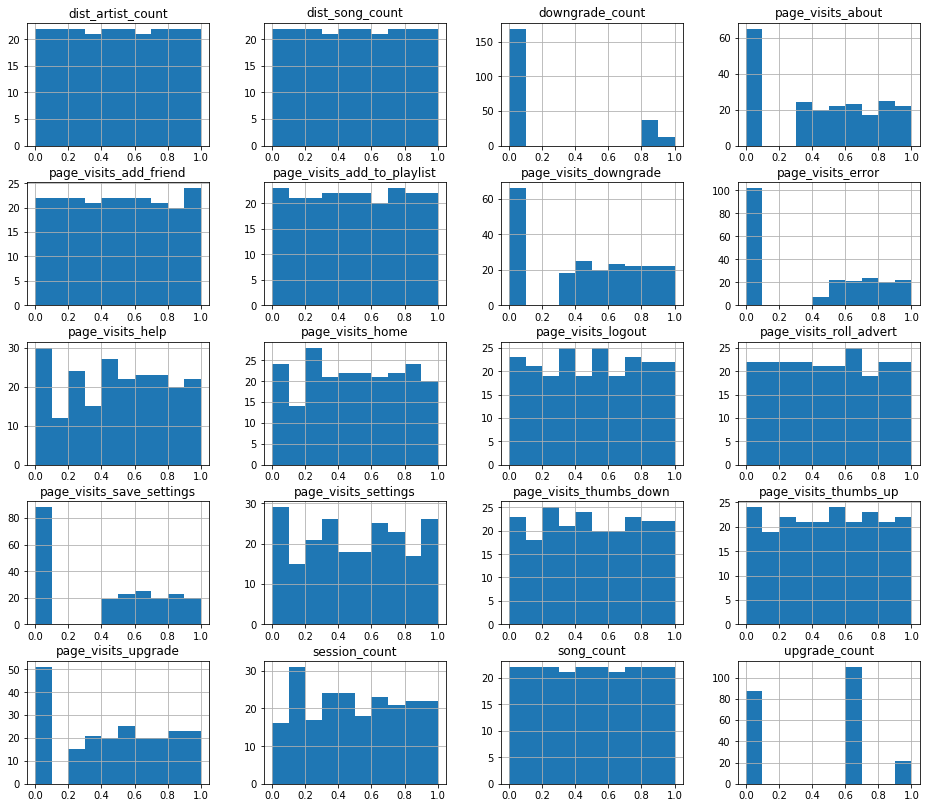

In [143]:
df_div.drop(columns = ['churn']).hist(figsize = (16,14))

In [144]:
df_div.describe()

,song_count,dist_song_count,dist_artist_count,session_count,downgrade_count,upgrade_count,churn,page_visits_home,page_visits_logout,page_visits_settings,...,page_visits_thumbs_down,page_visits_thumbs_up,page_visits_upgrade,page_visits_downgrade,page_visits_roll_advert,page_visits_about,page_visits_add_to_playlist,page_visits_add_friend,page_visits_help,page_visits_error
count,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,218.000000,2.180000e+02,2.180000e+02,2.180000e+02,...,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02,2.180000e+02
mean,5.000192e-01,5.000045e-01,4.999995e-01,4.988153e-01,1.999477e-01,4.216465e-01,0.206422,5.000490e-01,4.993775e-01,4.914229e-01,...,4.956740e-01,4.998138e-01,4.731864e-01,4.547221e-01,4.971192e-01,4.561312e-01,4.992956e-01,4.972144e-01,4.907751e-01,3.911312e-01
std,2.906682e-01,2.906636e-01,2.906705e-01,2.922605e-01,3.729123e-01,3.554037e-01,0.405668,2.906004e-01,2.915742e-01,3.037150e-01,...,2.976220e-01,2.908905e-01,3.264500e-01,3.446861e-01,2.953222e-01,3.434226e-01,2.918432e-01,2.952981e-01,3.044473e-01,3.845346e-01
min,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.000000,1.000000e-07,1.000000e-07,1.000000e-07,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07
25%,2.501877e-01,2.502069e-01,2.499211e-01,2.537538e-01,1.000000e-07,1.000000e-07,0.000000,2.501878e-01,2.394792e-01,2.501600e-01,...,2.499855e-01,2.502450e-01,2.498276e-01,1.000000e-07,2.582583e-01,1.000000e-07,2.422422e-01,2.532533e-01,2.498343e-01,1.000000e-07
50%,4.999237e-01,4.999409e-01,5.000276e-01,4.864865e-01,1.000000e-07,6.521522e-01,0.000000,4.998980e-01,5.485485e-01,5.000194e-01,...,4.929930e-01,5.000000e-01,5.090090e-01,4.994995e-01,4.919514e-01,5.000344e-01,4.975566e-01,5.000893e-01,5.000000e-01,5.010358e-01
75%,7.500755e-01,7.499759e-01,7.497797e-01,7.467467e-01,1.000000e-07,6.521522e-01,0.000000,7.502015e-01,7.467467e-01,7.547548e-01,...,7.307307e-01,7.527528e-01,7.487487e-01,7.499904e-01,7.487487e-01,7.478729e-01,7.500581e-01,7.467467e-01,7.497890e-01,7.605824e-01
max,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,1.000000,9.999999e-01,9.999999e-01,9.999999e-01,...,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 1. Supervised learning
Supervised learning algorithms train classifiers based on known input - output pairs. To evaluate the results the data must be split into training and testing data. To comapre different models we will use validation data.

In [145]:
# the number of users is low and the number of those who churned even lower
# let's repeat the splitting as long as we don't have at least 20% of churned users in both test and validate datasets
train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])
while (len(validate[validate['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) < len(df_div[df_div['churn']==1]) // 5) or \
        (len(test[test['churn']==1]) != len(validate[validate['churn']==1])):
        train, validate, test = np.split(df_div.sample(frac=1), [int(.6*len(df_div)), int(.8*len(df_div))])

In [146]:
X_val = validate.drop(columns = ['userID', 'churn'])
y_val = validate['churn']

X_test = test.drop(columns = ['userID', 'churn'])
y_test = test['churn']

X_train = train.drop(columns = ['userID', 'churn'])
y_train = train['churn']

We are dealing with imbalanced classes here. One way to account for that would be to downsample the majority class. This is  an easy way to balance data, but it also reduces the variability in the majority class and therefore the classifiers may be biased. For this reason we will upsample the minority class in the training data.

In [147]:
X_train = X_train.append(X_train[y_train == 1]).append(X_train[y_train == 1]).append(X_train[y_train == 1])
y_train = y_train.append(y_train[y_train == 1]).append(y_train[y_train == 1]).append(y_train[y_train == 1])

#### 1.1. Decision Tree

In [148]:
from sklearn import tree
import time

In [149]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
ts = time.time()
tree_clf.fit(X_train, y_train)
tree_train_time = time.time() - ts

In [150]:
ts = time.time()
y_pred_tree = tree_clf.predict(X_test)
tree_predict_time = time.time() - ts

In [151]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [152]:
f1_tree = f1_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)
recall_tree = recall_score(y_test, y_pred_tree)
print('Decision tree metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_tree, precision_tree, recall_tree))

Decision tree metrics:
 f1: 0.2857142857142857
 precision: 0.4
 recall: 0.2222222222222222


Text(0,0.5,'True')

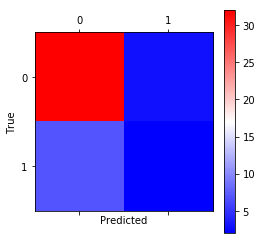

In [153]:
tree_conf_mat = confusion_matrix(y_test, y_pred_tree).astype('float64') 
plt.matshow(tree_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.2. Bagging algorithm: Random Forest
Random Forest creates multiple decision trees and counts their outputs as votes to classify a given data point.

In [154]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
rf_clf = RandomForestClassifier(random_state = 42)
ts = time.time()
rf_clf.fit(X_train, y_train)
rf_train_time = time.time() - ts

In [156]:
ts = time.time()
y_pred_rf = rf_clf.predict(X_test)
rf_predict_time = time.time() - ts

In [157]:
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
print('Random forest metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_rf, precision_rf, recall_rf))

Random forest metrics:
 f1: 0.1818181818181818
 precision: 0.5
 recall: 0.1111111111111111


Text(0,0.5,'True')

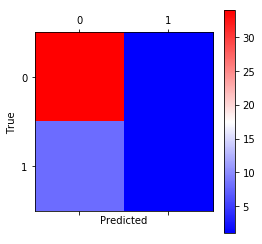

In [158]:
rf_conf_mat = confusion_matrix(y_test, y_pred_rf).astype('float64') 
plt.matshow(rf_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.3. Boosting algorithm: AdaBoost

In [159]:
from sklearn.ensemble import AdaBoostClassifier

In [160]:
ada_clf = AdaBoostClassifier(random_state = 42)
ts = time.time()
ada_clf.fit(X_train, y_train)
ada_train_time = time.time() - ts

In [161]:
ts = time.time()
y_pred_ada = ada_clf.predict(X_test)
ada_predict_time = time.time() - ts

In [162]:
f1_ada = f1_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
print('AdaBoost metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_ada, precision_ada, recall_ada))

AdaBoost metrics:
 f1: 0.0
 precision: 0.0
 recall: 0.0


Text(0,0.5,'True')

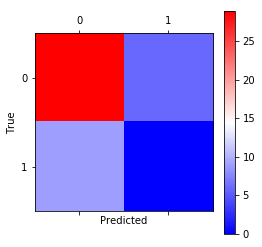

In [163]:
ada_conf_mat = confusion_matrix(y_test, y_pred_ada).astype('float64') 
plt.matshow(ada_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.4. Neural Network: Multi-Layer Perceptron

In [164]:
from sklearn.neural_network import MLPClassifier

In [165]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(7), random_state = 42, early_stopping = True)
ts = time.time()
mlp_clf.fit(X_train, y_train)
mlp_train_time = time.time() - ts

In [166]:
ts = time.time()
y_pred_mlp = mlp_clf.predict(X_test)
mlp_predict_time = time.time() - ts

In [167]:
f1_mlp = f1_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
print('Multi-Layer Perceptron metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_mlp, precision_mlp, recall_mlp))

Multi-Layer Perceptron metrics:
 f1: 0.339622641509434
 precision: 0.20454545454545456
 recall: 1.0


Text(0,0.5,'True')

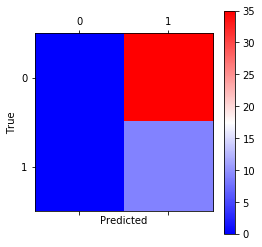

In [168]:
mlp_conf_mat = confusion_matrix(y_test, y_pred_mlp).astype('float64') 
plt.matshow(mlp_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.5. Gaussian Naive Bayes

In [169]:
from sklearn.naive_bayes import GaussianNB

In [170]:
gnb_clf = GaussianNB()
ts = time.time()
gnb_clf.fit(X_train, y_train)
gnb_train_time = time.time() - ts

In [171]:
ts = time.time()
y_pred_gnb = gnb_clf.predict(X_test)
gnb_predict_time = time.time() - ts

In [172]:
f1_gnb = f1_score(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb)
recall_gnb = recall_score(y_test, y_pred_gnb)
print('Gaussian naive bayes metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_gnb, precision_gnb, recall_gnb))

Gaussian naive bayes metrics:
 f1: 0.24242424242424243
 precision: 0.16666666666666666
 recall: 0.4444444444444444


Text(0,0.5,'True')

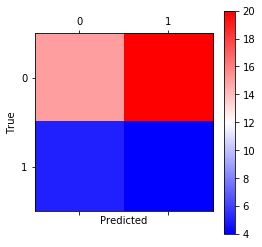

In [173]:
gnb_conf_mat = confusion_matrix(y_test, y_pred_gnb).astype('float64') 
plt.matshow(gnb_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.6. Linear Support Vector Classification

In [174]:
from sklearn.svm import LinearSVC

In [175]:
svc_clf = LinearSVC(random_state = 42, class_weight='balanced')
ts = time.time()
svc_clf.fit(X_train, y_train)
svc_train_time = time.time() - ts

In [176]:
ts = time.time()
y_pred_svc = svc_clf.predict(X_test)
svc_predict_time = time.time() - ts

In [177]:
f1_svc = f1_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
print('Linear Support Vector Classification metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_svc, precision_svc, recall_svc))

Linear Support Vector Classification metrics:
 f1: 0.3636363636363637
 precision: 0.3076923076923077
 recall: 0.4444444444444444


Text(0,0.5,'True')

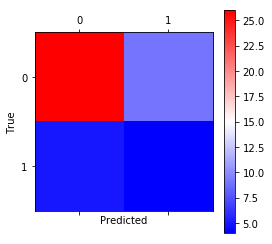

In [178]:
svc_conf_mat = confusion_matrix(y_test, y_pred_svc).astype('float64') 
plt.matshow(svc_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

#### 1.7. Logistic regression

In [179]:
from sklearn.linear_model import LogisticRegression

In [180]:
lr_clf = LogisticRegression(random_state = 42, class_weight='balanced', solver = 'saga')
ts = time.time()
lr_clf.fit(X_train, y_train)
lr_train_time = time.time() - ts

In [181]:
ts = time.time()
y_pred_lr = lr_clf.predict(X_test)
lr_predict_time = time.time() - ts

In [182]:
f1_lr = f1_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
print('Logistic Regression metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_lr, precision_lr, recall_lr))

Logistic Regression metrics:
 f1: 0.32
 precision: 0.25
 recall: 0.4444444444444444


Text(0,0.5,'True')

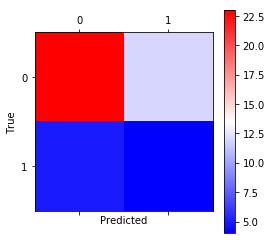

In [183]:
lr_conf_mat = confusion_matrix(y_test, y_pred_lr).astype('float64') 
plt.matshow(lr_conf_mat, cmap=plt.cm.bwr)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

In [184]:
y_pred_lr_val = lr_clf.predict(X_val)
y_pred_gnb_val = gnb_clf.predict(X_val)
y_pred_svc_val = svc_clf.predict(X_val)
y_pred_mlp_val = mlp_clf.predict(X_val)

#### 1.8. Selecting the best supervised learning model
We will use validation data to evaluate model predictions once again.

In [185]:
f1_lr_val = f1_score(y_val, y_pred_lr_val)
precision_lr_val = precision_score(y_val, y_pred_lr_val)
recall_lr_val = recall_score(y_val, y_pred_lr_val)
print('Logistic Regression validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_lr_val, precision_lr_val, recall_lr_val))

Logistic Regression validation metrics:
 f1: 0.631578947368421
 precision: 0.6
 recall: 0.6666666666666666


In [186]:
f1_svc_val = f1_score(y_val, y_pred_svc_val)
precision_svc_val = precision_score(y_val, y_pred_svc_val)
recall_svc_val = recall_score(y_val, y_pred_svc_val)
print('Linear Support Vector validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_svc_val, precision_svc_val, recall_svc_val))

Linear Support Vector validation metrics:
 f1: 0.5555555555555556
 precision: 0.5555555555555556
 recall: 0.5555555555555556


In [187]:
f1_mlp_val = f1_score(y_val, y_pred_mlp_val)
precision_mlp_val = precision_score(y_val, y_pred_mlp_val)
recall_mlp_val = recall_score(y_val, y_pred_mlp_val)
print('Multi Layer Perceptron validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_mlp_val, precision_mlp_val, recall_mlp_val))

Multi Layer Perceptron validation metrics:
 f1: 0.3461538461538462
 precision: 0.20930232558139536
 recall: 1.0


In [188]:
f1_gnb_val = f1_score(y_val, y_pred_gnb_val)
precision_gnb_val = precision_score(y_val, y_pred_gnb_val)
recall_gnb_val = recall_score(y_val, y_pred_gnb_val)
print('Gaussian Naive Bayes validation metrics:\n f1: {}\n precision: {}\n recall: {}'.format(f1_gnb_val, precision_gnb_val, recall_gnb_val))

Gaussian Naive Bayes validation metrics:
 f1: 0.33333333333333326
 precision: 0.23809523809523808
 recall: 0.5555555555555556


##### Conclusion
Logistic regressions still remains our best model. The F1 score of 0.63 is not exactly high, but we must take in consideration, that we trained the model on a very small part of our dataset. The difference in score between test and validation data shows that the randomization of the subsets can have great impact on the performance metrics in such setup.

### 2. Unsupervised learning.
Unsupervised learning methods do not require labels. Their goal is to discover intrinsic relationships in the data. Such methods can involve dimensionality reduction (Principal Components Analysis) or clustering (K-Means).

#### 2.1. Dimensionality reduction with PCA

The first 10 components explain 91.36% of variance.


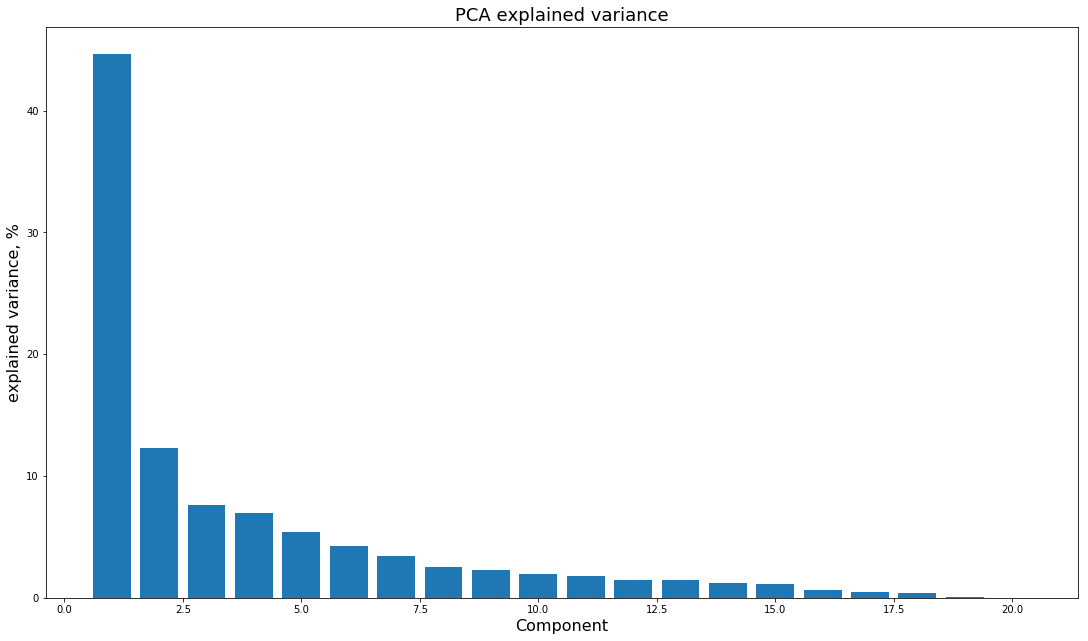

In [83]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42)
X = df_div.drop(columns = ['userID', 'churn'])
pca.fit(X)
plt.bar(range(1,21), 100*pca.explained_variance_ratio_)
plt.title('PCA explained variance', fontsize = 18)
plt.ylabel('explained variance, %', fontsize = 16)
plt.xlabel('Component', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
print('The first 10 components explain {:.2f}% of variance.'.format(100*pca.explained_variance_ratio_[:10].sum()))

In [84]:
pca = PCA(n_components = 5, random_state = 42)
X_pca = pca.fit_transform(X)

#### 2.2. Clustering with K-Means
We will apply K-Means to the transformed data to find the clusters of the users. In the next step we will see if churn can be localized to some of the clusters.

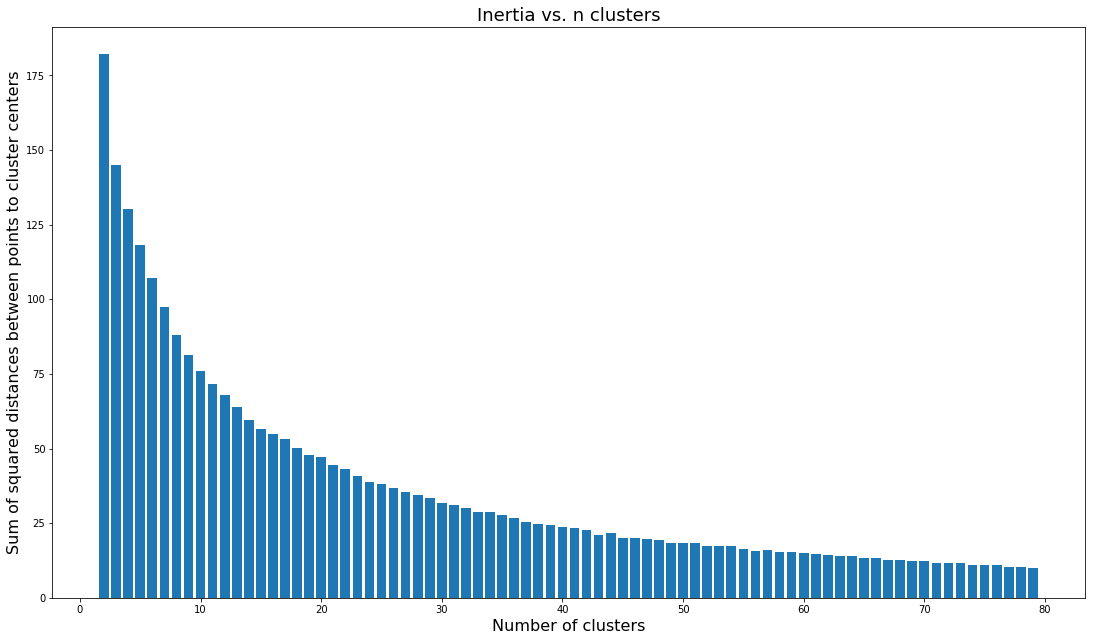

In [85]:
from sklearn.cluster import KMeans

inertia = []

for n_c in range(2,80):
    kmeans = KMeans(n_clusters = n_c, random_state = 42)
    kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)

plt.bar(range(2,80), inertia)
plt.title('Inertia vs. n clusters', fontsize = 18)
plt.ylabel('Sum of squared distances between points to cluster centers', fontsize = 16)
plt.xlabel('Number of clusters', fontsize = 16)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

Using the elbow method we take 15 clusters.

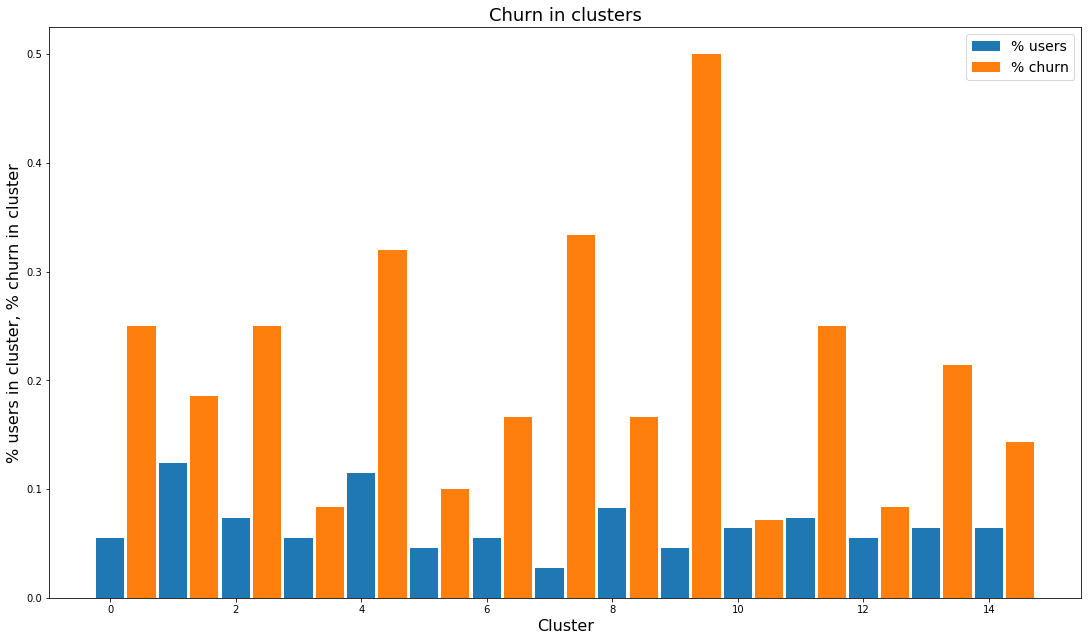

In [86]:
n_c = 15
kmeans = KMeans(n_clusters = n_c, random_state = 42)
labels = kmeans.fit_predict(X_pca).tolist()
df_kmeans = pd.DataFrame.from_dict({'userID':df_div['userID'].tolist(), 'churn':df_div['churn'].tolist(), 'cluster':labels})
plt.bar(np.arange(0,n_c), df_kmeans.groupby('cluster')['churn'].count()/len(df_kmeans), width = 0.45, label = '% users')
plt.bar(np.arange(0,n_c) + 0.5, df_kmeans.groupby('cluster')['churn'].mean().tolist(), width = 0.45, label = '% churn')
plt.title('Churn in clusters', fontsize = 18)
plt.ylabel('% users in cluster, % churn in cluster', fontsize = 16)
plt.xlabel('Cluster', fontsize = 16)
plt.legend(fontsize = 14)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [87]:
df_cluster_churn = pd.DataFrame.from_dict({'user count':df_kmeans.groupby('cluster')['churn'].count().tolist(),
                                           'churn count':df_kmeans.groupby('cluster')['churn'].sum()})

In [88]:
df_cluster_churn

,user count,churn count
cluster,,
0,12,3
1,27,5
2,16,4
3,12,1
4,25,8
5,10,1
6,12,2
7,6,2
8,18,3


##### Conclusion
Unfortunately unsupervised learning didn't yield the results we would like to get. Although some clusters have a high percentage of churn we can't find the optimal number of clusters from the small dataset.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [202]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify.ipynb'])

0